## Estimación de la frecuencia cardíaca combinando análisis temporal y espectral

Este notebook implementa un enfoque para estimar la frecuencia cardíaca  a partir de señales PPG crudas (en este caso, la señal infrarroja IR). Se aplican dos estrategias complementarias:

1. **Análisis en el dominio del tiempo**  
   - Se preprocesa la señal eliminando los primeros 5 segundos, y se resta la contribución ambiental (IR - AMB_IR).  
   - Se aplica un filtrado paso bajo para atenuar el ruido de alta frecuencia.  
   - La señal se normaliza con Z-Score robusto (basado en mediana y rango intercuartílico).  
   - Se detectan los picos de cada latido mediante un algoritmo adaptativo, ajustando dinámicamente el umbral y la distancia mínima entre picos.
   - Se calcula la frecuencia cardíaca como la inversa del intervalo mediano entre picos (expresado en BPM).

2. **Análisis en el dominio de la frecuencia (espectral)**  
   - Se aplica un filtro paso banda [0.5–3 Hz] para aislar el rango fisiológico de frecuencia cardíaca.  
   - Se calcula la densidad espectral de potencia (PSD) usando el método de Welch.  
   - Se estima la HR como la frecuencia dominante del espectro, y también se analiza en ventanas móviles (análisis por tramos).

3. **Fusión de resultados**  
   - Se calcula la media entre la frecuencia estimada por picos y la estimada por espectro para obtener una medida final más robusta.

El resultado se visualiza en tres niveles: la señal con los picos detectados, la densidad espectral con la frecuencia dominante, y un histograma con las HR estimadas por tramos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import numpy as np

# 1. Cargar los datos
file_path = file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_92_76.csv"
data = pd.read_csv(file_path)
data = data[data['Tiempo (ms)'] >= 5000]

# Opcional: Resetear el tiempo para que empiece en 0
data['Tiempo (ms)'] = data['Tiempo (ms)'] - 5000
tiempo = data['Tiempo (ms)']
IR = data['IR']
RED = data['RED']

IR_clean = IR - data['AMB_IR']
RED_clean = RED - data['AMB_RED']

IR_normalized = (IR_clean - IR_clean.mean()) / IR_clean.std()
RED_normalized = (RED_clean - RED_clean.mean()) / RED_clean.std()

In [2]:
from scipy.signal import butter, filtfilt

#Eliminar ruido de alta frecuencia con un filtro pasa bajos inicia

def lowpass_filter(signal, cutoff=5, fs=60, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

#Normalizar usando Z-Score adaptativo (reduce el impacto de outliers):

IR_lowpass = lowpass_filter(IR_clean)  # Aplicar antes de la normalización
RED_lowpass = lowpass_filter(RED_clean)

In [3]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs=60, lowcut=0.5, highcut=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

IR_filtered = bandpass_filter(IR_normalized)

In [4]:
IR_normalized = (IR_lowpass - np.median(IR_lowpass)) / (np.quantile(IR_lowpass, 0.75) - np.quantile(IR_lowpass, 0.25))

In [5]:
from scipy.signal import welch

freqs, psd = welch(IR_filtered, fs=60, nperseg=512)
dominant_freq = freqs[np.argmax(psd)]
heart_rate_fft = dominant_freq * 60

In [6]:
heart_rates = []
for i in range(0, len(IR_filtered), 600):  # Ventanas de 10 segundos
    segment = IR_filtered[i:i+600]
    if len(segment) < 100: break
    freqs, psd = welch(segment, fs=60, nperseg=256)
    dominant_freq = freqs[np.argmax(psd)]
    heart_rates.append(dominant_freq * 60)
heart_rate_fft = np.median(heart_rates)

In [7]:
def adaptive_peak_detection(signal, min_distance=40, dynamic_threshold=True):
    peaks = []
    threshold = 0.5 * np.std(signal)
    for i in range(1, len(signal)-1):
        if dynamic_threshold:
            threshold = 0.5 * np.std(signal[max(0, i-100):i+100])
        if (signal[i] > signal[i-1] and 
            signal[i] > signal[i+1] and 
            signal[i] > threshold and 
            (len(peaks) == 0 or i - peaks[-1] > min_distance)):
            peaks.append(i)
    return np.array(peaks)

peaks = adaptive_peak_detection(IR_filtered)

In [8]:
if len(peaks) >= 2:
    intervals = np.diff(tiempo.iloc[peaks] / 1000)  # Convertir a segundos
    heart_rate_time = 60 / np.median(intervals)
else:
    heart_rate_time = None  # No hay suficientes picos
n_picos =np.median(intervals)

In [9]:
if heart_rate_time is not None:
    final_hr = np.mean([heart_rate_fft, heart_rate_time])
else:
    final_hr = heart_rate_fft
print(f"Frecuencia cardíaca final: {final_hr:.1f} lpm")

Frecuencia cardíaca final: 84.1 lpm


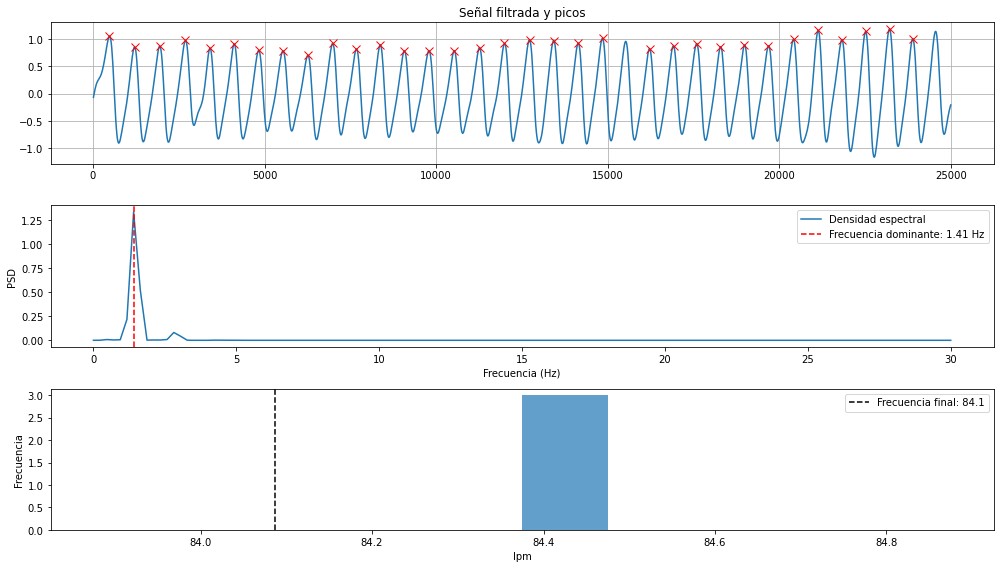

In [10]:
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(tiempo, IR_filtered, label='IR filtrada')
plt.plot(tiempo.iloc[peaks], IR_filtered[peaks], 'rx', markersize=8, label='Picos detectados')
plt.title('Señal filtrada y picos')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(freqs, psd, label='Densidad espectral')
plt.axvline(dominant_freq, color='r', linestyle='--', label=f'Frecuencia dominante: {dominant_freq:.2f} Hz')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.legend()

plt.subplot(3, 1, 3)
plt.hist(heart_rates, bins=10, alpha=0.7)
plt.axvline(final_hr, color='k', linestyle='--', label=f'Frecuencia final: {final_hr:.1f}')
plt.xlabel('lpm')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

raw_data_91_91.csv – FC estimada: 93.5 BPM


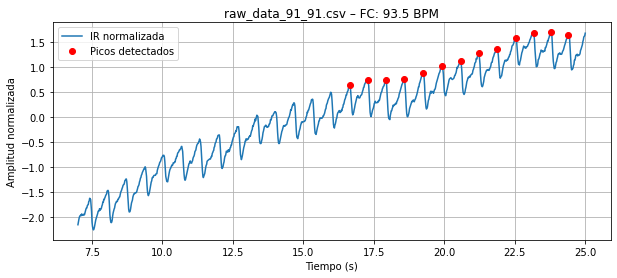

raw_data_92_76.csv – FC estimada: 83.8 BPM
Error en raw_data_92_76.csv: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([7, 33, 76, 120, 165], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"
raw_data_93_100.csv – FC estimada: 97.4 BPM


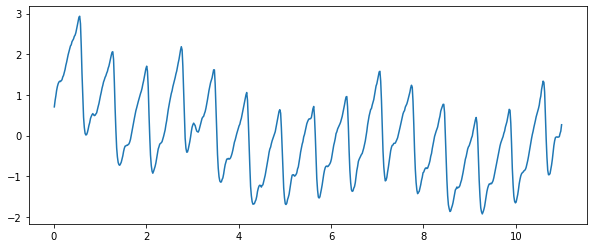

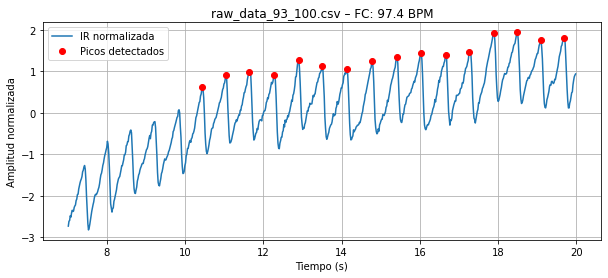

raw_data_95_77_2.csv – FC estimada: 80.1 BPM


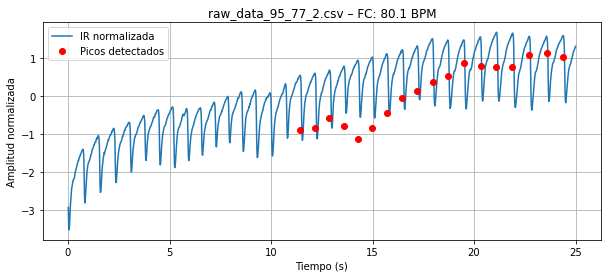

raw_data_95_80.csv – FC estimada: 72.8 BPM
Error en raw_data_95_80.csv: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([14, 64, 114, 165], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"
raw_data_95_81_papa.csv – FC estimada: 80.1 BPM
Error en raw_data_95_81_papa.csv: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([36, 82, 128, 173], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"
raw_data_95_99.csv – FC estimada: 96.1 BPM
Error en raw_data_95_99.csv: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([10, 49, 88], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#de

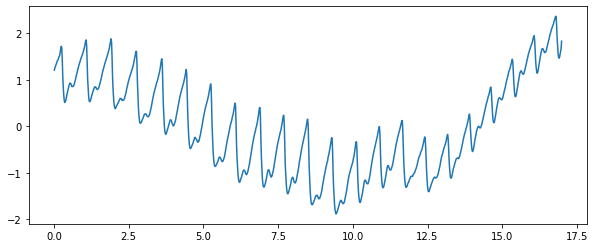

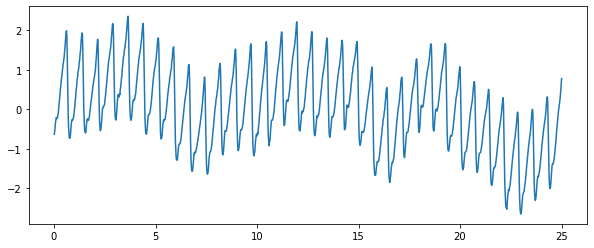

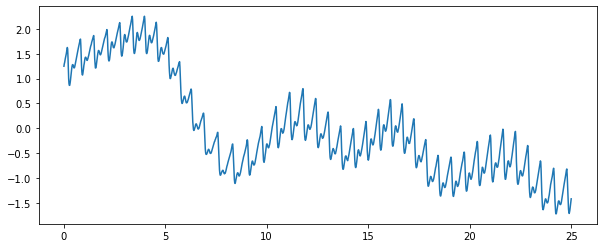

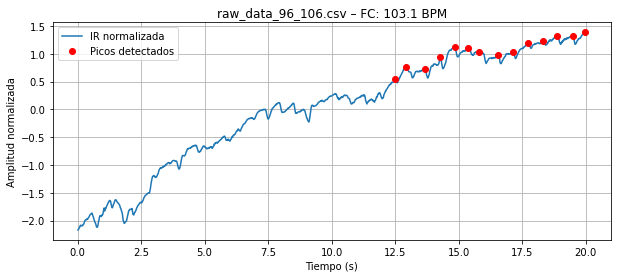

raw_data_96_69.csv – FC estimada: 68.6 BPM


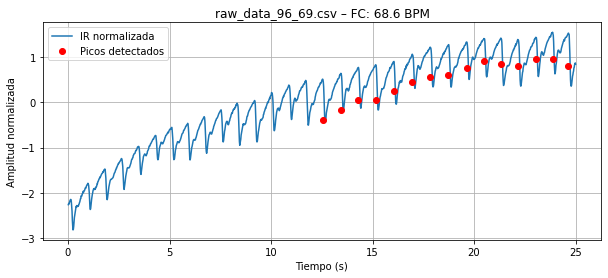

raw_data_97_119.csv – FC estimada: 116.3 BPM


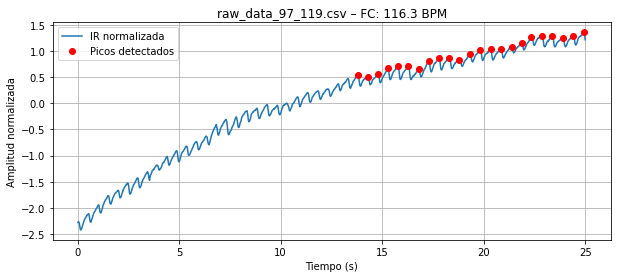

raw_data_97_95.csv – FC estimada: 94.8 BPM


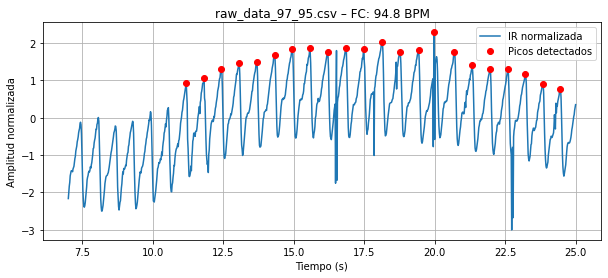

raw_data_98_81.csv – FC estimada: 80.1 BPM


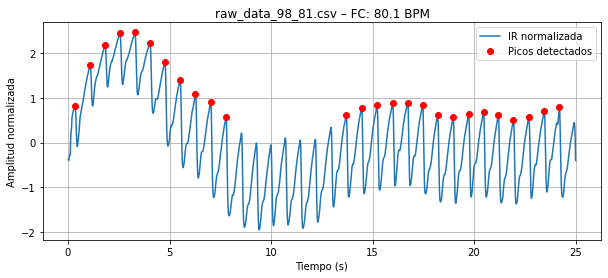

raw_data_98_86.csv – FC estimada: 85.7 BPM


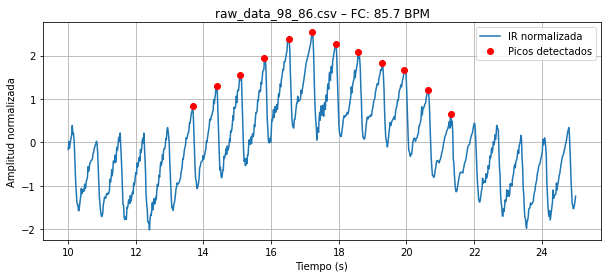

raw_data_98_91.csv – FC estimada: 91.2 BPM


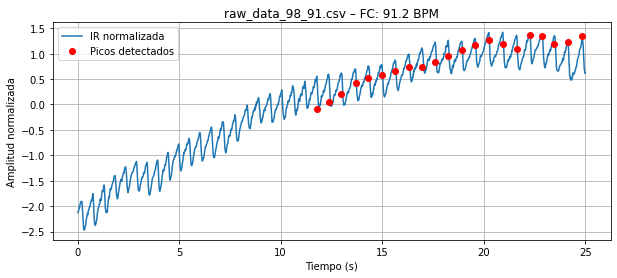

raw_data_99_75.csv – FC estimada: 75.0 BPM


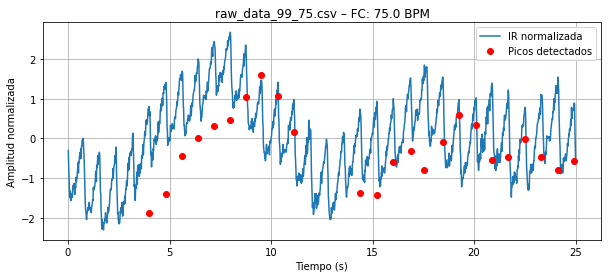

raw_data_99_91.csv – FC estimada: 80.1 BPM


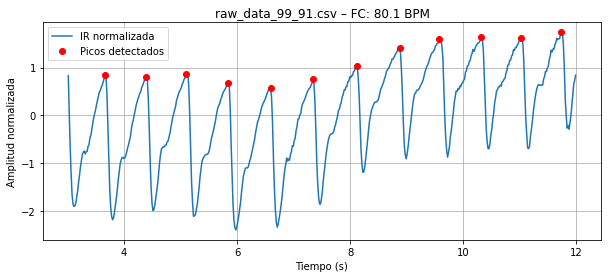

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def procesar_archivo(file_path):
    try:
        data = pd.read_csv(file_path)

        if not all(col in data.columns for col in ['Tiempo (ms)', 'IR', 'RED', 'AMB_IR', 'AMB_RED']):
            print(f" {os.path.basename(file_path)} no tiene todas las columnas necesarias.")
            return

        # Recortar los primeros 5 segundos
        data = data[data['Tiempo (ms)'] >= 5000].copy()
        data['Tiempo (ms)'] = data['Tiempo (ms)'] - 5000
        tiempo = data['Tiempo (ms)'].values / 1000  # convertir a segundos

        # Limpieza de señal
        IR_clean = data['IR'] - data['AMB_IR']
        RED_clean = data['RED'] - data['AMB_RED']

        # Normalización z-score
        IR_normalized = (IR_clean - IR_clean.mean()) / IR_clean.std()
        RED_normalized = (RED_clean - RED_clean.mean()) / RED_clean.std()

        # Detección de picos
        peaks, _ = find_peaks(IR_normalized, height=0.5, distance=fs*0.4)  # mínimo 0.4s (~150 bpm)
        tiempos_picos = tiempo[peaks]

        # Cálculo de frecuencia cardíaca
        if len(tiempos_picos) >= 2:
            rr_intervals = np.diff(tiempos_picos)
            hr_bpm = 60 / np.median(rr_intervals)
            print(f"{os.path.basename(file_path)} – FC estimada: {hr_bpm:.1f} BPM")
        else:
            hr_bpm = None
            print(f" {os.path.basename(file_path)} – No se detectaron suficientes picos.")

        # (Opcional) Visualizar señal y picos
        plt.figure(figsize=(10, 4))
        plt.plot(tiempo, IR_normalized, label="IR normalizada")
        if len(tiempos_picos) > 0:
            plt.plot(tiempos_picos, IR_normalized[peaks], 'ro', label="Picos detectados")
        plt.title(f"{os.path.basename(file_path)} – FC: {hr_bpm:.1f} BPM" if hr_bpm else "Sin FC")
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Amplitud normalizada")
        plt.grid(True)
        plt.legend()
        plt.show()

        return hr_bpm

    except Exception as e:
        print(f"Error en {os.path.basename(file_path)}: {e}")
        return None

# Parámetros
fs = 60  # Frecuencia de muestreo en Hz
carpeta = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"

# Procesar todos los archivos
for archivo in os.listdir(carpeta):
    if archivo.endswith(".csv"):
        ruta = os.path.join(carpeta, archivo)
        procesar_archivo(ruta)


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import re

# Parámetros
fs = 60  # Hz
carpeta = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"
resultados = []

# Procesar cada archivo
for archivo in os.listdir(carpeta):
    if archivo.endswith(".csv"):
        ruta = os.path.join(carpeta, archivo)
        try:
            data = pd.read_csv(ruta)

            # Verificar columnas
            required_cols = ['Tiempo (ms)', 'IR', 'RED', 'AMB_IR', 'AMB_RED']
            if not all(col in data.columns for col in required_cols):
                print(f" {archivo} no tiene todas las columnas necesarias.")
                continue

            # Recorte y tiempo en segundos
            data = data[data['Tiempo (ms)'] >= 5000].copy()
            data['Tiempo (ms)'] -= 5000
            tiempo = data['Tiempo (ms)'].values / 1000

            # Limpieza y normalización
            IR_clean = data['IR'] - data['AMB_IR']
            RED_clean = data['RED'] - data['AMB_RED']
            IR_norm = (IR_clean - IR_clean.mean()) / IR_clean.std()
            RED_norm = (RED_clean - RED_clean.mean()) / RED_clean.std()

            # Detección de picos
            peaks, _ = find_peaks(IR_norm, height=0.5, distance=fs * 0.4)
            tiempos_picos = tiempo[peaks]

            if len(tiempos_picos) >= 2:
                rr_intervals = np.diff(tiempos_picos)
                hr_bpm = 60 / np.median(rr_intervals)
            else:
                hr_bpm = np.nan

        except Exception as e:
            print(f" Error en {archivo}: {e}")
            hr_bpm = np.nan

        # FC esperada desde nombre archivo
        match = re.match(r".*_(\d+)_(\d+)", archivo)
        expected_hr = int(match.group(2)) if match else None

        resultados.append({
            "Archivo": archivo,
            "FC esperada (bpm)": expected_hr,
            "FC estimada (bpm)": round(hr_bpm, 2) if not np.isnan(hr_bpm) else "Error"
        })


# Crear tabla
tabla = pd.DataFrame(resultados)
print(tabla)

# Guardar CSV
csv_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados_temporal_fft.csv"
tabla.to_csv(csv_path, index=False)

# Guardar como imagen
fig, ax = plt.subplots(figsize=(11, len(tabla) * 0.5 + 1))
ax.axis('off')
tabla_img = ax.table(cellText=tabla.values,
                     colLabels=tabla.columns,
                     cellLoc='center',
                     loc='center')
tabla_img.auto_set_font_size(False)
tabla_img.set_fontsize(10)
tabla_img.scale(1, 1.5)

png_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados_temporal_fft.png"
plt.savefig(png_path, bbox_inches='tight', dpi=300)
plt.close()

                    Archivo  FC esperada (bpm)  FC estimada (bpm)
0        raw_data_91_91.csv                 91              93.53
1        raw_data_92_76.csv                 76              83.80
2       raw_data_93_100.csv                100              97.40
3      raw_data_95_77_2.csv                  2              80.11
4        raw_data_95_80.csv                 80              72.82
5   raw_data_95_81_papa.csv                 81              80.05
6        raw_data_95_99.csv                 99              96.08
7       raw_data_96_106.csv                106             103.09
8        raw_data_96_69.csv                 69              68.65
9       raw_data_97_119.csv                119             116.28
10       raw_data_97_95.csv                 95              94.79
11       raw_data_98_81.csv                 81              80.11
12       raw_data_98_86.csv                 86              85.71
13       raw_data_98_91.csv                 91              91.19
14       r